<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Regressao_pre%C3%A7o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics as m
from tensorflow import keras


from  sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# **Manipulação dos Dados**

## Importação dos Dados

In [121]:
X = pd.read_csv('X.csv').iloc[:,1:]
X.head(5)

,floors,grade,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,sqft_above,tendencia,dia,QtdOutLiers-1,QtdOutLiers-2,QtdOutLiers-3,QtdOutLiers-4,QtdOutLiers-5,QtdOutLiers-6,QtdOutLiers-7
0,1,8,3,4,3.0,47.7591,2480,1260,98077,1620,4.142857,0.0,6.0,7.0,6.0,5.0,0.0,0.0,3.0
1,1,7,2,4,3.0,47.3092,1920,1920,98023,1510,4.142857,0.0,6.0,7.0,6.0,5.0,0.0,0.0,3.0
2,1,9,2,3,4.0,47.7642,2430,2750,98077,2430,4.142857,0.0,6.0,7.0,6.0,5.0,0.0,0.0,3.0
3,3,8,2,3,3.0,47.7265,1352,1439,98125,1352,4.142857,0.0,6.0,7.0,6.0,5.0,0.0,0.0,3.0
4,2,8,2,3,4.0,47.3397,3060,2090,98010,3060,4.142857,0.0,6.0,7.0,6.0,5.0,0.0,0.0,3.0


In [122]:
Y = pd.read_csv('Y.csv').iloc[:,1:]
Y.head(5)

,price
0,610000.0
1,260000.0
2,590000.0
3,325000.0
4,415000.0


## Transformação dos Dados

In [123]:
X.columns

Index(['floors', 'grade', 'bathrooms', 'condition', 'bedrooms', 'lat',
       'sqft_living', 'sqft_living15', 'zipcode', 'sqft_above', 'tendencia',
       'dia', 'QtdOutLiers-1', 'QtdOutLiers-2', 'QtdOutLiers-3',
       'QtdOutLiers-4', 'QtdOutLiers-5', 'QtdOutLiers-6', 'QtdOutLiers-7'],
      dtype='object')

In [124]:
columnsMinMax = ['floors',
                 'bathrooms',
                 'grade',
                 'lat',
                 'condition',
                 'bedrooms',
                 'zipcode',
                 'QtdOutLiers-1', 'QtdOutLiers-2', 'QtdOutLiers-3',
                 'QtdOutLiers-4', 'QtdOutLiers-5', 'QtdOutLiers-6',
                 'QtdOutLiers-7','tendencia'
                 ]
columnsMinMax

['floors',
 'bathrooms',
 'grade',
 'lat',
 'condition',
 'bedrooms',
 'zipcode',
 'QtdOutLiers-1',
 'QtdOutLiers-2',
 'QtdOutLiers-3',
 'QtdOutLiers-4',
 'QtdOutLiers-5',
 'QtdOutLiers-6',
 'QtdOutLiers-7',
 'tendencia']

In [125]:
columnsStander = ['sqft_above','sqft_living15','sqft_living',]
columnsStander

['sqft_above', 'sqft_living15', 'sqft_living']

In [126]:
'''
ohe = OneHotEncoder().fit(X['month'].values.reshape(-1, 1))
columns_month = ohe.transform(X['month'].values.reshape(-1, 1)).toarray()

for indice in range(len(columns_month[0])):
    X[f'mes {indice}'] = columns_month[:,indice]
'''

"\nohe = OneHotEncoder().fit(X['month'].values.reshape(-1, 1))\ncolumns_month = ohe.transform(X['month'].values.reshape(-1, 1)).toarray()\n\nfor indice in range(len(columns_month[0])):\n    X[f'mes {indice}'] = columns_month[:,indice]\n"

In [127]:
ohe = OneHotEncoder().fit(X['dia'].values.reshape(-1, 1))
columns_month = ohe.transform(X['dia'].values.reshape(-1, 1)).toarray()

for indice in range(len(columns_month[0])):
    X[f'dia {indice}'] = columns_month[:,indice]


In [128]:
X.drop(['dia'],axis='columns',inplace=True)

In [129]:
X.head(3)

,floors,grade,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,sqft_above,...,QtdOutLiers-5,QtdOutLiers-6,QtdOutLiers-7,dia 0,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6
0,1,8,3,4,3.0,47.7591,2480,1260,98077,1620,...,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7,2,4,3.0,47.3092,1920,1920,98023,1510,...,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,9,2,3,4.0,47.7642,2430,2750,98077,2430,...,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
scale_price = StandardScaler()
scale_price.fit(Y['price'].values.reshape(len(Y),1))
Y['price'] = scale_price.transform(Y['price'].values.reshape(len(Y),1))

scaleMinMax = []

for column in range(len(columnsMinMax)):
    scaleMinMax.append(StandardScaler())
    scaleMinMax[column].fit(X[columnsMinMax[column]].values.reshape(len(X),1))
    X[columnsMinMax[column]] = scaleMinMax[column].transform(X[columnsMinMax[column]].values.reshape(len(X),1))


scaleStander = []
for column in range(len(columnsStander)):
    scaleStander.append(MinMaxScaler())
    scaleStander[column].fit(X[columnsStander[column]].values.reshape(len(X),1))
    X[columnsStander[column]] = scaleStander[column].transform(X[columnsStander[column]].values.reshape(len(X),1))


In [131]:
X.head(3)

,floors,grade,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,sqft_above,...,QtdOutLiers-5,QtdOutLiers-6,QtdOutLiers-7,dia 0,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6
0,-0.809654,0.292303,1.703913,0.908964,-0.398659,1.437253,0.186224,0.148167,-0.017174,0.155193,...,-1.082787,-1.40226,-0.856154,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.809654,-0.557498,0.341464,0.908964,-0.398659,-1.806424,0.138605,0.261745,-1.026206,0.142357,...,-1.082787,-1.40226,-0.856154,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.809654,1.142105,0.341464,-0.628908,0.677928,1.474023,0.181973,0.404578,-0.017174,0.249708,...,-1.082787,-1.40226,-0.856154,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Divisão dos Dados

In [132]:
X_train,X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
Y_train,Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

In [133]:
X_train.head(3)

,floors,grade,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,sqft_above,...,QtdOutLiers-5,QtdOutLiers-6,QtdOutLiers-7,dia 0,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6
0,-0.809654,0.292303,1.703913,0.908964,-0.398659,1.437253,0.186224,0.148167,-0.017174,0.155193,...,-1.082787,-1.40226,-0.856154,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.809654,-0.557498,0.341464,0.908964,-0.398659,-1.806424,0.138605,0.261745,-1.026206,0.142357,...,-1.082787,-1.40226,-0.856154,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.809654,1.142105,0.341464,-0.628908,0.677928,1.474023,0.181973,0.404578,-0.017174,0.249708,...,-1.082787,-1.40226,-0.856154,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Rede Neural**

## Modelo 1

### Definição do Modelo

In [134]:
X.columns

Index(['floors', 'grade', 'bathrooms', 'condition', 'bedrooms', 'lat',
       'sqft_living', 'sqft_living15', 'zipcode', 'sqft_above', 'tendencia',
       'QtdOutLiers-1', 'QtdOutLiers-2', 'QtdOutLiers-3', 'QtdOutLiers-4',
       'QtdOutLiers-5', 'QtdOutLiers-6', 'QtdOutLiers-7', 'dia 0', 'dia 1',
       'dia 2', 'dia 3', 'dia 4', 'dia 5', 'dia 6'],
      dtype='object')

In [135]:
model_1 = keras.Sequential([
    keras.layers.Dense(12,activation='elu',input_shape=[len(X_train.columns)]),
    keras.layers.Dense(12,activation='elu'),
    keras.layers.Dense(1)
])

In [136]:
optimizer = keras.optimizers.RMSprop(0.1,)
model_1.compile(
    loss='mse',
    metrics=['mae','mse','mape']
)

In [137]:
history_1 = model_1.fit(
    x=X_train,
    y=Y_train,
    epochs = 1000,
    verbose = 0
)

In [138]:
hist1_df = pd.DataFrame(history_1.history)

### Métricas

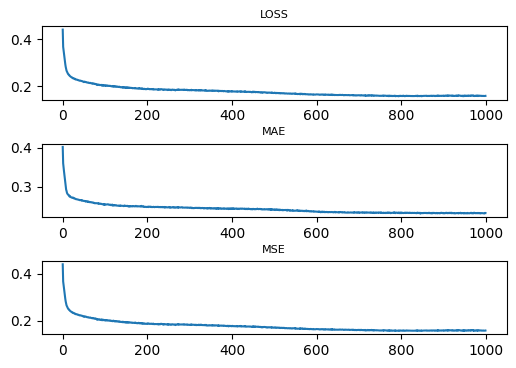

In [139]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

ax=fig.add_subplot(3,1,1)
ax.set_title('LOSS',fontsize=8)
plt.plot(hist1_df.loss)


ax=fig.add_subplot(3,1,2)
ax.set_title('MAE',fontsize=8)
plt.plot(hist1_df.mae)


ax=fig.add_subplot(3,1,3)
ax.set_title('MSE',fontsize=8)
plt.plot(hist1_df.mse)


In [140]:
metrics_train = model_1.evaluate(X_train,Y_train)
print("metricas treino")
print(f"Loss = {metrics_train[0]}")
print(f"MAE = {metrics_train[1]}")
print(f"MSE = {metrics_train[2]}")
print(f"MAPE = {metrics_train[3]}")

print("metricas teste")
metrics_test = model_1.evaluate(X_test,Y_test)
print(f"Loss = {metrics_test[0]}")
print(f"MAE = {metrics_test[1]}")
print(f"MSE = {metrics_test[2]}")
print(f"MAPE = {metrics_test[3]}")

530/530 [==============================] - 1s 1ms/step - loss: 0.1538 - mae: 0.2350 - mse: 0.1538 - mape: 370.3244
metricas treino
Loss = 0.1538364440202713
MAE = 0.23503585159778595
MSE = 0.1538364440202713
MAPE = 370.3243713378906
metricas teste
133/133 [==============================] - 0s 1ms/step - loss: 0.1907 - mae: 0.2552 - mse: 0.1907 - mape: 451.5302
Loss = 0.19069010019302368
MAE = 0.25523248314857483
MSE = 0.19069010019302368
MAPE = 451.5301513671875


In [141]:
predict_1 = model_1.predict(X_test).flatten()

133/133 [==============================] - 0s 866us/step


### Análise de Resíduos

In [142]:
residuos_1 = Y_test['price']-predict_1

Text(0.5, 0, 'Previsão')

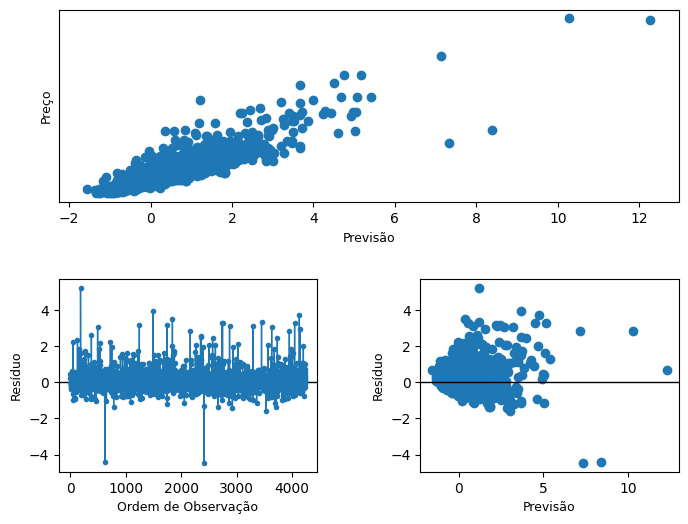

In [143]:
fig=plt.figure(figsize=(8,6))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax=fig.add_subplot(2,2,3)

plt. axhline(y=0,xmin=0,xmax=len(residuos_1),color='black', linewidth=1)
plt.plot(range(len(residuos_1)),residuos_1,marker='.', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Ordem de Observação',fontsize=9)

ax=fig.add_subplot(2,1,1)

plt.scatter(predict_1,Y_test['price'])
plt.yticks([])
plt.ylabel('Preço', fontsize=9)
plt.xlabel('Previsão',fontsize=9)



ax=fig.add_subplot(2,2,4)

plt.scatter(predict_1,residuos_1)
plt.axhline(y=0,xmin=0,xmax=len(predict_1),color='black', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Previsão',fontsize=9)

### Previsões

In [144]:
m.r2_score(Y_test['price'],predict_1)

0.8094813144050469

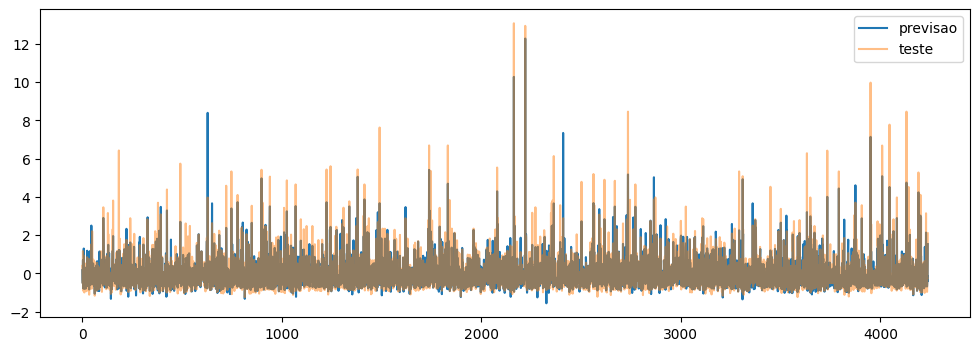

In [145]:
ig=plt.figure(figsize=(12,4))
plt.plot(range(len(predict_1)),predict_1,label='previsao')
plt.plot(range(len(Y_test)),Y_test['price'],alpha=0.5,label='teste')
plt.legend()

## Modelo 2

### Definição do Modelo

In [146]:
X.drop([f'QtdOutLiers-{i}' for i in range(1,8)],
  axis='columns', inplace=True)

In [147]:
X

,floors,grade,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,sqft_above,tendencia,dia 0,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6
0,-0.809654,0.292303,1.703913,0.908964,-0.398659,1.437253,0.186224,0.148167,-0.017174,0.155193,-0.064343,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.809654,-0.557498,0.341464,0.908964,-0.398659,-1.806424,0.138605,0.261745,-1.026206,0.142357,-0.064343,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.809654,1.142105,0.341464,-0.628908,0.677928,1.474023,0.181973,0.404578,-0.017174,0.249708,-0.064343,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.818083,0.292303,0.341464,-0.628908,-0.398659,1.202214,0.090306,0.178971,0.879743,0.123921,-0.064343,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.004214,0.292303,0.341464,-0.628908,0.677928,-1.586526,0.235544,0.291000,-1.269121,0.323221,-0.064343,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21186,-0.809654,-0.557498,-1.020984,-0.628908,-0.398659,-0.657907,0.074830,0.282395,2.056947,0.102684,-2.265207,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21187,1.004214,0.292303,0.341464,-0.628908,-1.475245,1.048646,0.091837,0.167097,1.029229,0.092182,-2.265207,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21188,-0.809654,-0.557498,0.341464,-0.628908,1.754514,0.254850,0.134354,0.253141,-1.325179,0.184364,-2.265207,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21189,-0.809654,-1.407299,-1.020984,-0.628908,-1.475245,0.949151,0.093537,0.089658,0.692885,0.050175,-3.103632,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [148]:
X_train,X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
Y_train,Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

In [149]:
model_2 = keras.Sequential([
    keras.layers.Dense(13,activation='elu',input_shape=[len(X_train.columns)]),
    keras.layers.Dense(13,activation='elu'),
    keras.layers.Dense(1)
])

In [150]:
optimizer = keras.optimizers.RMSprop(0.1,)
model_2.compile(
    loss='mse',
    metrics=['mae','mse','mape']
)

In [151]:
history_2 = model_2.fit(
    x=X_train,
    y=Y_train,
    epochs = 1000,
    verbose = 0
)

In [152]:
hist2_df = pd.DataFrame(history_2.history)

### Métricas

([<matplotlib.axis.XTick at 0x7e9a11c2a2c0>,
 [Text(0, 0, '0'), Text(100, 0, '100')])

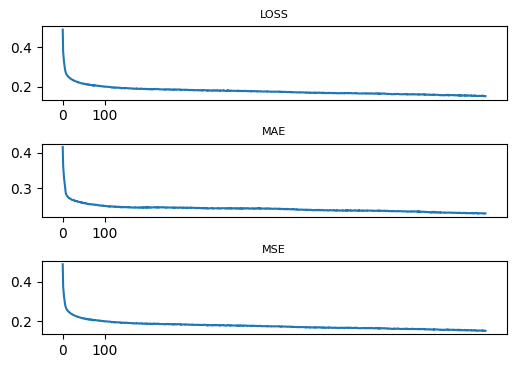

In [153]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

ax=fig.add_subplot(3,1,1)
ax.set_title('LOSS',fontsize=8)
plt.plot(hist2_df.loss)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,2)
ax.set_title('MAE',fontsize=8)
plt.plot(hist2_df.mae)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,3)
ax.set_title('MSE',fontsize=8)
plt.plot(hist2_df.mse)
plt.xticks([0,100])

In [154]:
metrics_train = model_2.evaluate(X_train,Y_train)
print("metricas treino")
print(f"Loss = {metrics_train[0]}")
print(f"MAE = {metrics_train[1]}")
print(f"MSE = {metrics_train[2]}")
print(f"MAPE = {metrics_train[3]}")


metrics_test = model_2.evaluate(X_test,Y_test)
print("metricas teste")
print(f"Loss = {metrics_test[0]}")
print(f"MAE = {metrics_test[1]}")
print(f"MSE = {metrics_test[2]}")
print(f"MAPE = {metrics_test[3]}")

530/530 [==============================] - 1s 1ms/step - loss: 0.1530 - mae: 0.2386 - mse: 0.1530 - mape: 377.0425
metricas treino
Loss = 0.15299217402935028
MAE = 0.23863162100315094
MSE = 0.15299217402935028
MAPE = 377.04254150390625
133/133 [==============================] - 0s 1ms/step - loss: 0.1767 - mae: 0.2425 - mse: 0.1767 - mape: 434.2039
metricas teste
Loss = 0.1766786426305771
MAE = 0.2425108253955841
MSE = 0.1766786426305771
MAPE = 434.2038879394531


In [155]:
predict_2 = model_2.predict(X_test).flatten()

133/133 [==============================] - 0s 921us/step


### Análise de Resíduos

In [156]:
residuos_2 = Y_test['price']-predict_2

Text(0.5, 0, 'Previsão')

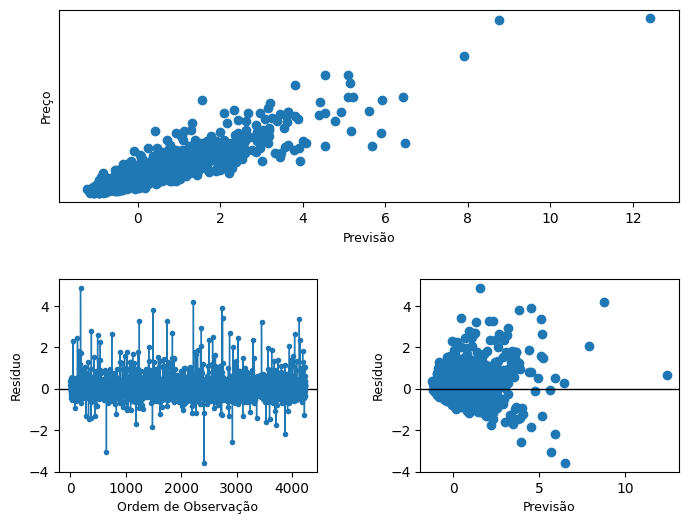

In [157]:
fig=plt.figure(figsize=(8,6))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax=fig.add_subplot(2,2,3)

plt. axhline(y=0,xmin=0,xmax=len(residuos_2),color='black', linewidth=1)
plt.plot(range(len(residuos_2)),residuos_2,marker='.', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Ordem de Observação',fontsize=9)

ax=fig.add_subplot(2,1,1)

plt.scatter(predict_2,Y_test['price'])
plt.yticks([])
plt.ylabel([], fontsize=0)
plt.ylabel('Preço', fontsize=9)
plt.xlabel('Previsão',fontsize=9)



ax=fig.add_subplot(2,2,4)

plt.scatter(predict_2,residuos_2)
plt.axhline(y=0,xmin=0,xmax=len(predict_2),color='black', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Previsão',fontsize=9)

### Previsões

In [158]:
m.r2_score(Y_test['price'],predict_2)

0.8234802095822976

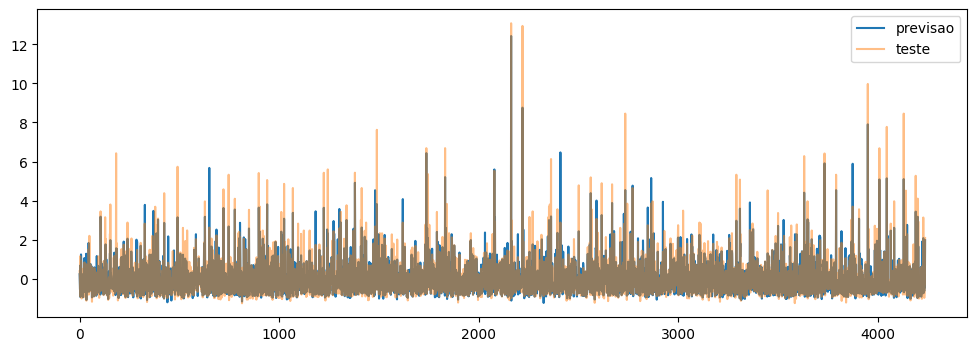

In [159]:
ig=plt.figure(figsize=(12,4))
plt.plot(range(len(predict_2)),predict_2,label='previsao')
plt.plot(range(len(Y_test)),Y_test['price'],alpha=0.5,label='teste')
plt.legend()

## Modelo 3

### Definição do Modelo

In [160]:
X.columns

Index(['floors', 'grade', 'bathrooms', 'condition', 'bedrooms', 'lat',
       'sqft_living', 'sqft_living15', 'zipcode', 'sqft_above', 'tendencia',
       'dia 0', 'dia 1', 'dia 2', 'dia 3', 'dia 4', 'dia 5', 'dia 6'],
      dtype='object')

In [161]:
X.drop('tendencia',
  axis='columns', inplace=True)

In [162]:
X

,floors,grade,bathrooms,condition,bedrooms,lat,sqft_living,sqft_living15,zipcode,sqft_above,dia 0,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6
0,-0.809654,0.292303,1.703913,0.908964,-0.398659,1.437253,0.186224,0.148167,-0.017174,0.155193,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.809654,-0.557498,0.341464,0.908964,-0.398659,-1.806424,0.138605,0.261745,-1.026206,0.142357,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.809654,1.142105,0.341464,-0.628908,0.677928,1.474023,0.181973,0.404578,-0.017174,0.249708,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.818083,0.292303,0.341464,-0.628908,-0.398659,1.202214,0.090306,0.178971,0.879743,0.123921,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.004214,0.292303,0.341464,-0.628908,0.677928,-1.586526,0.235544,0.291000,-1.269121,0.323221,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21186,-0.809654,-0.557498,-1.020984,-0.628908,-0.398659,-0.657907,0.074830,0.282395,2.056947,0.102684,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21187,1.004214,0.292303,0.341464,-0.628908,-1.475245,1.048646,0.091837,0.167097,1.029229,0.092182,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21188,-0.809654,-0.557498,0.341464,-0.628908,1.754514,0.254850,0.134354,0.253141,-1.325179,0.184364,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21189,-0.809654,-1.407299,-1.020984,-0.628908,-1.475245,0.949151,0.093537,0.089658,0.692885,0.050175,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [163]:
X_train,X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
Y_train,Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

In [164]:
model_3 = keras.Sequential([
    keras.layers.Dense(13,activation='elu',input_shape=[len(X_train.columns)]),
    keras.layers.Dense(13,activation='elu'),
    keras.layers.Dense(1)
])

In [165]:
optimizer = keras.optimizers.RMSprop(0.1,)
model_3.compile(
    loss='mse',
    metrics=['mae','mse','mape']
)

In [166]:
history_3 = model_3.fit(
    x=X_train,
    y=Y_train,
    epochs = 1000,
    verbose = 0
)

In [167]:
hist3_df = pd.DataFrame(history_3.history)

### Métricas

([<matplotlib.axis.XTick at 0x7e9a1182f040>,
 [Text(0, 0, '0'), Text(100, 0, '100')])

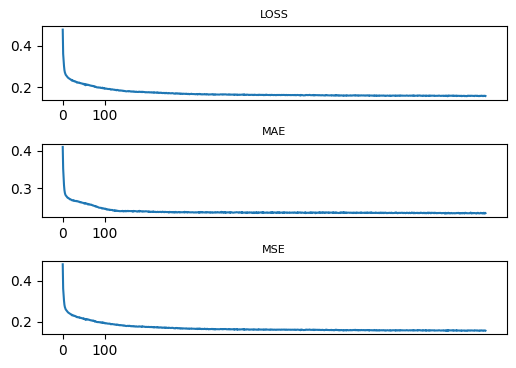

In [168]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0.3, hspace=0.6)

ax=fig.add_subplot(3,1,1)
ax.set_title('LOSS',fontsize=8)
plt.plot(hist3_df.loss)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,2)
ax.set_title('MAE',fontsize=8)
plt.plot(hist3_df.mae)
plt.xticks([0,100])

ax=fig.add_subplot(3,1,3)
ax.set_title('MSE',fontsize=8)
plt.plot(hist3_df.mse)
plt.xticks([0,100])

In [169]:
metrics_train = model_3.evaluate(X_train,Y_train)
print("metricas treino")
print(f"Loss = {metrics_train[0]}")
print(f"MAE = {metrics_train[1]}")
print(f"MSE = {metrics_train[2]}")
print(f"MAPE = {metrics_train[3]}")


metrics_test = model_3.evaluate(X_test,Y_test)
print("metricas teste")
print(f"Loss = {metrics_test[0]}")
print(f"MAE = {metrics_test[1]}")
print(f"MSE = {metrics_test[2]}")
print(f"MAPE = {metrics_test[3]}")

530/530 [==============================] - 1s 1ms/step - loss: 0.1582 - mae: 0.2245 - mse: 0.1582 - mape: 360.5758
metricas treino
Loss = 0.15821731090545654
MAE = 0.22449930012226105
MSE = 0.15821731090545654
MAPE = 360.5758361816406
133/133 [==============================] - 0s 1ms/step - loss: 0.2326 - mae: 0.2698 - mse: 0.2326 - mape: 477.4765
metricas teste
Loss = 0.23261278867721558
MAE = 0.2698315680027008
MSE = 0.23261278867721558
MAPE = 477.4765319824219


In [170]:
predict_3 = model_3.predict(X_test).flatten()

133/133 [==============================] - 0s 948us/step


In [171]:
residuos_3 = Y_test['price']-predict_3

### Análise de Resíduos

Text(0.5, 0, 'Previsão')

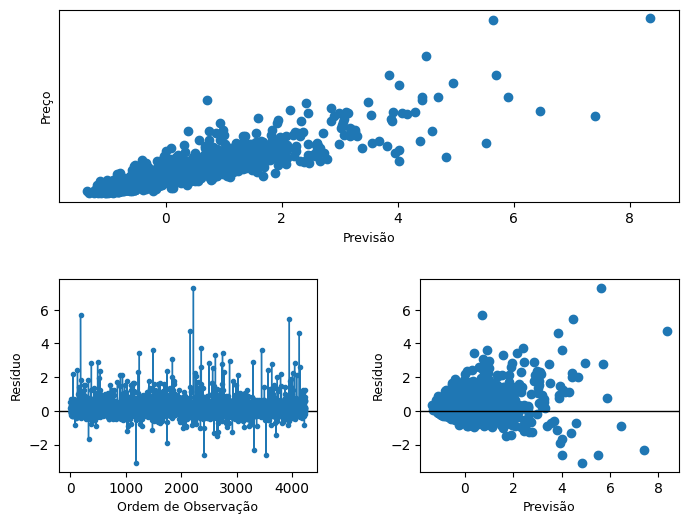

In [172]:
fig=plt.figure(figsize=(8,6))

plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax=fig.add_subplot(2,2,3)

plt. axhline(y=0,xmin=0,xmax=len(residuos_3),color='black', linewidth=1)
plt.plot(range(len(residuos_3)),residuos_3,marker='.', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Ordem de Observação',fontsize=9)

ax=fig.add_subplot(2,1,1)

plt.scatter(predict_3,Y_test['price'])
plt.yticks([])
plt.ylabel([], fontsize=0)
plt.ylabel('Preço', fontsize=9)
plt.xlabel('Previsão',fontsize=9)



ax=fig.add_subplot(2,2,4)

plt.scatter(predict_3,residuos_3)
plt.axhline(y=0,xmin=0,xmax=len(predict_3),color='black', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Previsão',fontsize=9)

### Previsões

In [173]:
m.r2_score(Y_test['price'],predict_3)

0.7675963711719189

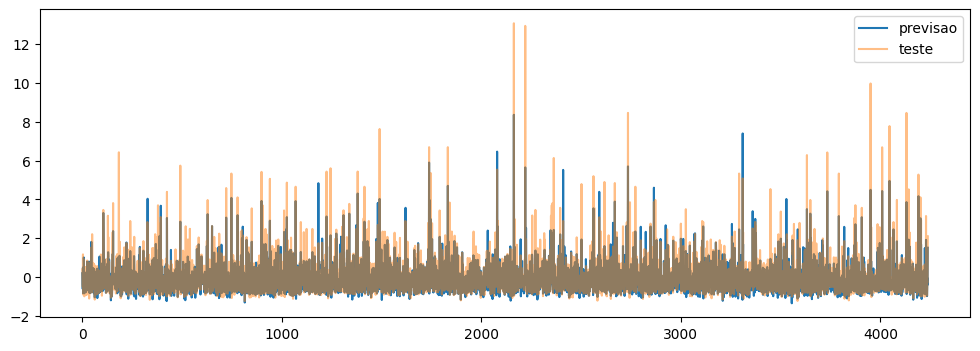

In [174]:
ig=plt.figure(figsize=(12,4))
plt.plot(range(len(predict_3)),predict_3,label='previsao')
plt.plot(range(len(Y_test)),Y_test['price'],alpha=0.5,label='teste')
plt.legend()

# Conclusão

Por enquanto não teve uma comparação muito embasada a partir do k-fold

Que fique bem claro que foi apenas em uma execução, não tem como tirar resultados razoáveis para comparações com apenas uma execução.

O primeiro modelo parece se sair bem melhor a dados outliers, pela análise de resíduos, pois note que o primeiro gráfico, os pontos com valores mais altos ainda tendem a se manterem pertos da reta identidade. Enquanto os outros tendem a se dispersarem a medida que os valores crescem, causando um efeito de cone.

